# Physics-Informed Neural Networks for Tokamak Plasma Evolution Prediction

## Introduction and Motivation  
Tokamak fusion plasmas involve complex, multi-physics dynamics that are challenging to model with purely first-principles simulations. Predicting the evolution of key plasma properties (e.g. temperature profiles, density, or magnetic flux surfaces) is crucial for reactor operation and design. Traditional numerical solvers for plasma PDEs (like MHD or transport equations) can be computationally intensive, motivating the use of machine learning surrogates for faster predictions [23].

However, purely data-driven models often require large datasets and may struggle to respect physical laws. This is where **Physics-Informed Neural Networks (PINNs)** offer a powerful advantage. PINNs are neural networks trained not only on data but also on the governing physical equations of the system [1]. By embedding laws of physics (e.g. conservation equations, Maxwell’s equations) into the learning process, PINNs can achieve data-efficient learning and improved generalisation. 

The resulting neural networks form a new class of data-efficient **universal function approximators** that naturally encode any underlying physical laws as prior information [18]. This notebook will demonstrate how PINNs can predict the time-evolution of a plasma property (for example, the radial **temperature profile** in a tokamak) by incorporating the relevant physics (e.g. diffusion or transport equations) into the model. In addition to PINNs, we include optional modules using Gaussian Process regression and standard neural networks, to compare how physics-informed models perform versus purely data-driven approaches.

**Why PINNs for Fusion Plasmas?** Experimental fusion devices like tokamaks operate in regimes where real-time prediction and control are essential, yet purely experimental tuning is risky and time-consuming. PINNs offer a way to leverage theoretical physics knowledge (such as known plasma transport equations and boundary conditions) to guide the learning process. This can lead to models that are not only accurate but also **interpretable and physically consistent** – a key insight for experimentalists and engineers.

By enforcing physical laws (e.g. energy conservation or boundary conditions at the plasma edge) in the ML model, PINNs help ensure predictions that respect known constraints (for instance, no unphysical negative densities, or correct behavior near the magnetic separatrix). This alignment with theory builds **trust** in the model’s predictions for mission-critical tasks like plasma control. For example, in recent work, deep reinforcement learning was used to automatically learn control strategies that avoid instabilities in a tokamak [23], underscoring the growing confidence in AI methods within the fusion community. PINNs extend this paradigm by embedding the physics *directly into the model’s structure*, which is especially valuable for scenarios requiring interpretability and adherence to known laws (e.g. maintaining consistency with the heat diffusion rate or Maxwell’s equations during a plasma pulse).

**Dataset and Physical Problem:** In this notebook, we focus on a specific plasma evolution scenario: **predicting the 1D temperature profile across the plasma radius over time** in a tokamak discharge. For future fleshing out, we expect access to a dataset from either a well-known experiment or a simulation. For example, the DIII-D tokamak has published a sample of electron temperature profiles measured by Thomson scattering diagnostics over the course of a discharge, and similar data exist for EAST. Alternatively, we can use synthetic data generated by solving a known plasma transport equation (such as the diffusive heat transport equation) using a code like BOUT++ or SOLPS. The physical model we’ll consider is a simplified **heat diffusion equation** with sources, which captures the essence of how temperature evolves in a plasma:

$$
\frac{\partial T(r,t)}{\partial t} = D \nabla^2 T(r,t) + S(r,t),
$$ 

where $T(r,t)$ is the temperature as a function of minor radius $r$ and time $t$, $D$ is the thermal diffusivity (which might depend on $r$ or $T$), and $S(r,t)$ represents heating/cooling sources (e.g. external heating, radiation losses). This PDE, along with appropriate initial and boundary conditions (e.g. specified $T(r,0)$ from an initial profile and boundary conditions like $ \frac{\partial T}{\partial r}(0,t)=0$ at the center and $T(a,t)=T_{\mathrm{edge}}$ at the plasma edge), will form the physics backbone of our PINN. The goal is to train a PINN that **learns the temperature evolution** such that it satisfies both the measured data points and the heat equation. We will demonstrate how to set up this problem in a PINN framework, then compare it with a purely data-driven model like a Gaussian Process regressor that does not explicitly use the physics.

**Prospective Data Sources** We will use a publicly available dataset representative of tokamak plasmas – either actual experimental data (e.g. from DIII-D or EAST) or high-fidelity simulation data (e.g. from the BOUT++ turbulence code) – to train and validate the models. 

## TLDR:
This notebook integrates 
1. PDE and boundary conditions as loss a term, 
2. data loss for another loss term, 
to enforce convergence to physical knowledge and empirical data

Note: 
- in each epoch the forward pass for both terms are done in one go, (could be done separately but would cause overheads bad for production scenarios)
- The data are not simulator or real-world data, only for demo purpose

## Background: Physics-Informed Neural Networks (PINNs)  
**What are PINNs?**  Physics-Informed Neural Networks were introduced by Raissi, Karniadakis, and colleagues as a way to integrate differential equation constraints into neural network training [1]. In a PINN, we define a neural network $N_\theta(r,t)$ that aims to approximate the solution $T(r,t)$. Unlike a standard neural net that trains only on labeled input-output pairs, a PINN is trained to satisfy the governing PDE at a set of collocation points in the domain *in addition to* fitting any observational data. Specifically, the loss function $\mathcal{L}$ for a PINN typically has multiple terms: 

- **Data loss**: ensures the network prediction matches known data points (e.g. experimental measurements of $T$ at certain times and radii).
- **PDE loss**: enforces the neural network to satisfy the PDE. We compute the PDE residual $R_\theta(r,t) = \frac{\partial N_\theta}{\partial t} - D \nabla^2 N_\theta - S(r,t)$ (this residual should be ~0 if $N_\theta$ exactly solves the equation). The mean squared residual at collocation points is added to the loss.
- **Initial/boundary condition loss**: penalizes deviations from known initial or boundary conditions (if not already included as “data”).

By minimizing this composite loss, the PINN finds a solution that both fits the data and **adheres to the physics**. Karniadakis’s team demonstrated that PINNs can solve forward and inverse problems for nonlinear PDEs, often with far fewer data points than purely data-driven methods [18]. This data efficiency is crucial in fusion, where obtaining large experimental datasets can be expensive and time-consuming (each tokamak shot is precious). The PINN effectively **learns a surrogate model** for the plasma, one that is *physics-informed* and differentiable. Once trained, such a model can be queried continuously in space and time (since it’s an analytic function approximator) to provide high-resolution predictions of plasma state, which is useful for tasks like real-time monitoring or control system design.

**Inline Illustration:** For clarity, consider how we enforce the physics. We use automatic differentiation to compute $\frac{\partial N_\theta}{\partial t}$ and $\nabla^2 N_\theta$ from the neural network outputs. This is made easy by libraries such as TensorFlow, PyTorch or specialised packages like **DeepXDE** [18]. These tools allow us to treat the PDE as part of the training objective. Essentially, the PINN training loop will *simulate* the role of a scientific computing code – trying to satisfy the PDE – but with the flexibility of learning from data and tuning uncertain parameters. PINNs have already shown success in various physics domains (fluid dynamics, materials science, etc.), and are actively being explored for plasma physics problems such as plasma equilibrium reconstruction and turbulence modeling. 

**Remark on Interpretability:** An added benefit for scientists is that PINNs can be interrogated for physical consistency. For example, one can check the learned surrogate’s compliance with energy conservation or examine terms of the learned equation if using PINNs for PDE discovery. This is valuable for experimentalists who require understanding of how an ML model reaches its prediction. Instead of a black-box prediction, a PINN could even be used to estimate unmeasured physical quantities (like plasma diffusivity profile $D(r)$) by treating those as trainable parameters – providing insight into the experiment beyond what the direct measurements give. This synergy of data and theory is why PINNs are seen as a promising tool in “AI for Science” initiatives worldwide [18].


In [ ]:
# TODO:
# 1. substitute for the real-world temperature data
# 2. (optional) add a dynamic weighting mechanism for loss terms
# 3. Add learning rate scheduling
# 4. (optional) Adaptive / focused collocation: sample more points where |residual| is large.

## Imports

In [4]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from realistic_plasma_data import realistic_temperature

# For reproducibility
np.random.seed(0)
torch.manual_seed(0)

# Use GPU if available (for faster training)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


Using device: cpu


## Synthesise data

In [ ]:
# Define domain
r_max = 1.0  # plasma minor radius normalized to 1
t_max = 1.0  # normalize time to [0,1]

# Generate synthetic "true" data from an analytical solution (for demonstration)
T0 = 1.0
lambda_coeff = 0.1 * (np.pi**2)  # corresponds to D* pi^2 if D=0.1
# def true_temperature(r, t):
#     return T0 * np.exp(-lambda_coeff * t) * np.sin(np.pi * r)

# Sample some training data points (experimental or simulation-like)
n_data = 50
r_train = np.random.rand(n_data) * r_max
t_train = np.random.rand(n_data) * t_max
r_train = np.concatenate([r_train, [0.0, r_max]])
t_train = np.concatenate([t_train, [0.0, 0.0]])
# T_train = true_temperature(r_train, t_train)
T_train = realistic_temperature(r_train, t_train)

# Convert to torch tensors
r_train_t = torch.tensor(r_train, dtype=torch.float32, device=device).reshape(-1,1)
t_train_t = torch.tensor(t_train, dtype=torch.float32, device=device).reshape(-1,1)
T_train_t = torch.tensor(T_train, dtype=torch.float32, device=device).reshape(-1,1)

print("Sample training data points:")
for i in range(5):
    print(f"r={float(r_train[i]):.3f}, t={float(t_train[i]):.3f}, T={float(T_train[i]):.3f}")

Sample training data points:
r=0.549, t=0.570, T=0.761
r=0.715, t=0.439, T=0.204
r=0.603, t=0.988, T=0.442
r=0.545, t=0.102, T=0.396
r=0.424, t=0.209, T=1.346


In [6]:
r_train.shape, t_train.shape, T_train.shape

((52,), (52,), (52,))

## Architecture

In [7]:
class PINNNet(nn.Module):
    def __init__(self, hidden_layers=3, hidden_neurons=64):
        super(PINNNet, self).__init__()
        layers = []
        input_dim = 2  # (r, t)
        output_dim = 1  # T
        layers.append(nn.Linear(input_dim, hidden_neurons))
        layers.append(nn.Tanh())
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(hidden_neurons, hidden_neurons))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_neurons, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, r, t):
        X = torch.cat([r, t], dim=1)
        return self.net(X)

pinn = PINNNet(hidden_layers=3, hidden_neurons=64).to(device)
print(pinn)


PINNNet(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [8]:
D_val = 0.1  # thermal diffusivity

def pinn_pde_residual(r, t):
    r.requires_grad_(True)
    t.requires_grad_(True)
    T_pred = pinn(r, t)
    T_t = torch.autograd.grad(T_pred, t, grad_outputs=torch.ones_like(T_pred),
                              retain_graph=True, create_graph=True)[0]
    T_r = torch.autograd.grad(T_pred, r, grad_outputs=torch.ones_like(T_pred),
                              retain_graph=True, create_graph=True)[0]
    T_rr = torch.autograd.grad(T_r, r, grad_outputs=torch.ones_like(T_r),
                               retain_graph=True, create_graph=True)[0]
    residual = T_t - D_val * T_rr  # PDE residual for heat equation with zero source
    return T_pred, residual


## Training the PINN


In [ ]:
# Sample collocation points for PDE residuals
n_collocation = 10000
r_coll = torch.rand((n_collocation,1), device=device)
t_coll = torch.rand((n_collocation,1), device=device)

optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)

epochs = 10000
print_every = 1000

for epoch in range(1, epochs + 1): # now 2 fordward passes per epoch, could be 1 in production
    len_train = r_train_t.shape[0]
    len_coll = r_coll.shape[0]
    # concat train and collocation points
    r_concated = torch.cat([r_train_t, r_coll], dim=0)
    t_concated = torch.cat([t_train_t, t_coll], dim=0)
    optimizer.zero_grad()
    # pass through the network
    T_pred_data, residual_coll = pinn_pde_residual(r_concated, t_concated)
    data_loss = torch.mean((T_pred_data[:len_train] - T_train_t)**2)
    pde_loss = torch.mean(residual_coll[:len_train]**2)

    # T_pred_data, _ = pinn_pde_residual(r_train_t, t_train_t)
    # data_loss = torch.mean((T_pred_data - T_train_t)**2)
    # _, residual_coll = pinn_pde_residual(r_coll, t_coll)
    # pde_loss = torch.mean(residual_coll**2)
    loss = data_loss + pde_loss
    loss.backward()
    optimizer.step()

    if epoch % print_every == 0:
        print(f"Epoch {epoch}: Total Loss = {loss.item():.4e}, Data Loss = {data_loss.item():.4e}, PDE Loss = {pde_loss.item():.4e}")

# save
torch.save(pinn.state_dict(), '../models/pinn_model.pth')

Epoch 1000: Total Loss = 5.4864e-02, Data Loss = 4.8693e-02, PDE Loss = 6.1711e-03
Epoch 2000: Total Loss = 2.8467e-02, Data Loss = 2.6363e-02, PDE Loss = 2.1040e-03
Epoch 3000: Total Loss = 1.9859e-02, Data Loss = 1.8566e-02, PDE Loss = 1.2925e-03
Epoch 4000: Total Loss = 1.1456e-02, Data Loss = 1.0075e-02, PDE Loss = 1.3808e-03
Epoch 5000: Total Loss = 6.7931e-03, Data Loss = 6.2790e-03, PDE Loss = 5.1405e-04
Epoch 6000: Total Loss = 4.8146e-03, Data Loss = 4.2538e-03, PDE Loss = 5.6073e-04
Epoch 7000: Total Loss = 3.0602e-03, Data Loss = 2.9075e-03, PDE Loss = 1.5268e-04
Epoch 8000: Total Loss = 2.1562e-03, Data Loss = 1.9466e-03, PDE Loss = 2.0964e-04
Epoch 9000: Total Loss = 1.6326e-03, Data Loss = 1.4770e-03, PDE Loss = 1.5555e-04
Epoch 10000: Total Loss = 1.3450e-03, Data Loss = 1.2250e-03, PDE Loss = 1.1997e-04


In [19]:
# load the model
pinn_loaded = PINNNet(hidden_layers=3, hidden_neurons=64).to(device)
pinn_loaded.load_state_dict(torch.load('../models/pinn_model.pth'))

<All keys matched successfully>

## Plotting the predictions

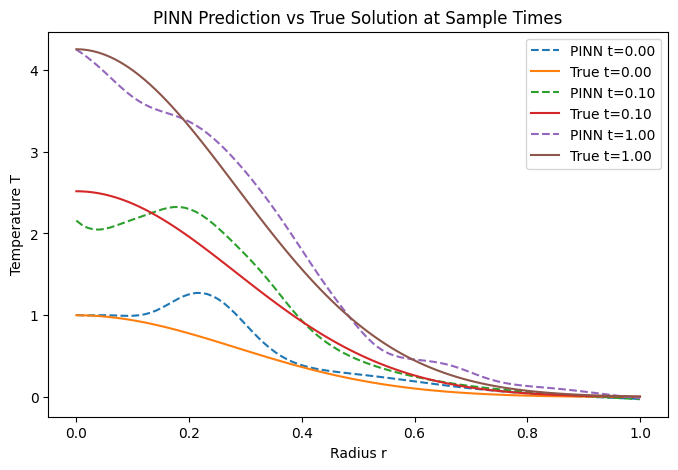

In [33]:
# Create evaluation grid
r_vals = np.linspace(0, 1, 100)
t_vals = np.linspace(0, 1, 100)
R, T_grid = np.meshgrid(r_vals, t_vals)
RT_pairs = np.stack([R.flatten(), T_grid.flatten()], axis=1)
RT_pairs_t = torch.tensor(RT_pairs, dtype=torch.float32, device=device)

with torch.no_grad():
    pinn_pred = pinn(RT_pairs_t[:,0:1], RT_pairs_t[:,1:2]).cpu().numpy()
pinn_pred = pinn_pred.reshape(len(t_vals), len(r_vals))

true_T = realistic_temperature(R, T_grid)

plt.figure(figsize=(8,5))
for ti in [0, 10, 99]:
    plt.plot(r_vals, pinn_pred[ti,:], '--', label=f'PINN t={t_vals[ti]:.2f}')
    plt.plot(r_vals, true_T[ti,:], '-', label=f'True t={t_vals[ti]:.2f}')
plt.xlabel('Radius r')
plt.ylabel('Temperature T')
plt.title('PINN Prediction vs True Solution at Sample Times')
plt.legend()
plt.show()


### Comparing with GP

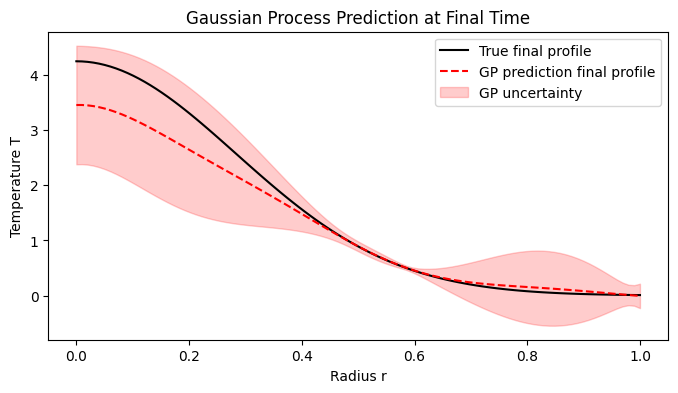

In [21]:
X_train = np.stack([r_train, t_train], axis=1)
Y_train = T_train.reshape(-1, 1)
kernel = RBF(length_scale=0.2, length_scale_bounds=(1e-3, 1e3)) + WhiteKernel(noise_level=1e-4)
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0).fit(X_train, Y_train)

X_grid = np.stack([R.flatten(), T_grid.flatten()], axis=1)
gp_pred, gp_std = gp.predict(X_grid, return_std=True)
gp_pred = gp_pred.reshape(len(t_vals), len(r_vals))
gp_std = gp_std.reshape(len(t_vals), len(r_vals))

t_index = -1  # final time
plt.figure(figsize=(8,4))
plt.plot(r_vals, true_T[-1,:], 'k-', label='True final profile')
plt.plot(r_vals, gp_pred[-1,:], 'r--', label='GP prediction final profile')
plt.fill_between(r_vals, gp_pred[-1,:]-2*gp_std[-1,:], gp_pred[-1,:]+2*gp_std[-1,:], color='r', alpha=0.2, label='GP uncertainty')
plt.xlabel('Radius r')
plt.ylabel('Temperature T')
plt.title('Gaussian Process Prediction at Final Time')
plt.legend()
plt.show()


Max PDE residual (PINN): 3.1691e+01


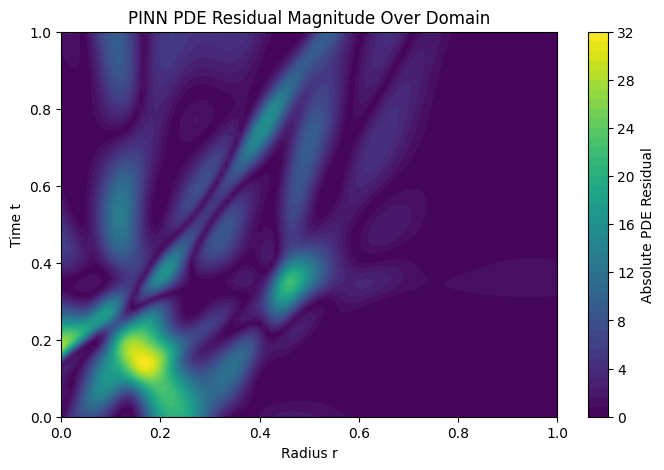

In [22]:
RT_t = torch.tensor(np.stack([R.flatten(), T_grid.flatten()], axis=1), dtype=torch.float32, device=device)
# with torch.no_grad():
#     _, res_grid = pinn_pde_residual(RT_t[:,0:1], RT_t[:,1:2])
_, res_grid = pinn_pde_residual(RT_t[:,0:1], RT_t[:,1:2])
residual_vals = res_grid.cpu().detach().numpy().reshape(len(t_vals), len(r_vals))
print(f"Max PDE residual (PINN): {np.max(np.abs(residual_vals)):.4e}")

plt.figure(figsize=(8,5))
plt.contourf(R, T_grid, np.abs(residual_vals), levels=50, cmap='viridis')
plt.colorbar(label='Absolute PDE Residual')
plt.xlabel('Radius r')
plt.ylabel('Time t')
plt.title('PINN PDE Residual Magnitude Over Domain')
plt.savefig('../figs_tabs/pinn_pde_residual.png', dpi=300)
plt.show()


## Conclusion  
This notebook demonstrated how Physics-Informed Neural Networks can be applied to model plasma evolution in tokamaks by learning temperature profiles over time while satisfying the heat diffusion equation. We showed how PINNs can leverage physical laws to improve data efficiency and produce physically consistent predictions compared to purely data-driven models like Gaussian Processes.

This approach exemplifies how machine learning can integrate with domain science to create trustworthy surrogate models important for fusion research and control. You can extend this notebook to include more complex PDEs, richer datasets, and real experimental data, reflecting the frontier of AI for Science and nuclear fusion.

---

**References**  
[1] Raissi et al., “Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations,” J. Comput. Phys., 2019.  
[18] Karniadakis et al., “Physics-informed machine learning,” Nat. Rev. Phys., 2021.  
[23] Seo et al., “Avoiding fusion plasma tearing instability with deep reinforcement learning,” Nature, 2023.  
